<a href="https://colab.research.google.com/github/monroyd1611/Gymnasium-ALE-Galaxian-v5-/blob/main/play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diego Francisco Monroy Figueroa
## Aprendizaje por Refuerzo
### mon23318@guvg.edu.gt
### Laboratorio #10

1. Objetivos y mecánicas del juego (Galaxian):
  
  • Objetivo principal del juego:

    - El objetivo principal de Galaxian es controlar una nave espacial (el jugador) y disparar a los enemigos que vienen en oleadas desde la parte superior de la pantalla. El jugador debe evitar ser alcanzado por los disparos enemigos y destruir todas las naves enemigas para avanzar al siguiente nivel.

  • Mecánica del juego:

    - El jugador controla la nave que se desplaza horizontalmente en la parte inferior de la pantalla, disparando proyectiles hacia las naves enemigas.
    - Las naves enemigas se mueven en patrones predecibles pero se vuelven más difíciles a medida que el juego progresa.
    - El jugador tiene vidas limitadas, y perder todas las vidas termina el juego.

  • Puntuación:

    - El puntaje se determina por la cantidad de naves enemigas destruidas. Cada nave enemiga tiene un valor de puntuación y se suman conforme se destruyen.
    - También pueden aparecer bonificaciones adicionales, como una nave extra, que aumenta el puntaje del jugador.


2. Definición del estado del entorno:

En ALE/Galaxian-v5, el estado del entorno se refiere a la representación de la situación actual del juego, que se pasa al agente (la política que el agente usa para tomar decisiones).

  • Estado del entorno en Galaxian:

    - El estado generalmente se representa como una imagen de 240x256 píxeles en color RGB que muestra:

      o La nave del jugador en la parte inferior de la pantalla.
      
      o Las naves enemigas que están posicionadas en la parte superior de la pantalla.
      
      o Disparos tanto del jugador como de los enemigos.
      
      o Otras posibles características del entorno, como bonificaciones.

El agente observa estas imágenes de la pantalla y usa esta información para decidir qué acción tomar en cada momento del juego.


3. Acciones disponibles:

En Galaxian, las acciones disponibles para el agente (el jugador) se limitan principalmente al movimiento de la nave y el disparo:

  • Acciones disponibles:
    
    - Mover a la izquierda (acción 0): Desplaza la nave del jugador hacia la izquierda de la pantalla.
    - Mover a la derecha (acción 1): Desplaza la nave del jugador hacia la derecha de la pantalla.
    - Disparar (acción 2): La nave dispara un proyectil hacia los enemigos.

In [1]:
!pip install stable-baselines3 torch ale-py shimmy imageio imageio-ffmpeg
!pip install AutoROM
!AutoROM --accept-license

"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"AutoROM" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# Librerías

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from collections import deque
import random
import imageio
from datetime import datetime
from pathlib import Path
import ale_py
import shimmy
import os


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Entorno y parámetros

In [3]:
class TrainingConfig:
    def __init__(self):
        self.learning_rate = 2.5e-4  # Aumentado para aprendizaje más rápido
        self.gamma = 0.99
        self.batch_size = 64  # Aumentado para estabilidad
        self.buffer_size = 50000  # Buffer más grande para más experiencias
        self.target_update = 500  # Actualización más frecuente
        self.epsilon_start = 1.0
        self.epsilon_end = 0.05  # Menor epsilon final para más explotación
        self.epsilon_decay = 0.999  # Decaimiento más lento
        self.n_episodes = 1000  # Más episodios de entrenamiento
        self.max_steps = 5000
        self.save_interval = 100  # Guardar cada 100 episodios

config = TrainingConfig()

# Implementando DQN

In [4]:
class EnhancedDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(EnhancedDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # Capa adicional
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularización
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Agente DQN

In [5]:
class EnhancedDQNAgent:
    def __init__(self, state_shape, n_actions, config):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = EnhancedDQN(state_shape, n_actions).to(self.device)
        self.target_net = EnhancedDQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config.learning_rate, weight_decay=1e-5)
        self.memory = ReplayBuffer(config.buffer_size)
        self.n_actions = n_actions
        self.config = config
        self.steps_done = 0
        self.epsilon = config.epsilon_start
        
        # Para seguimiento de mejores puntuaciones
        self.best_score = -float('inf')
        self.best_model_path = "dqn_best_model.pth"

    def select_action(self, state):
        sample = random.random()
        self.epsilon = max(self.config.epsilon_end, 
                          self.config.epsilon_start * (self.config.epsilon_decay ** self.steps_done))
        
        if sample > self.epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.n_actions)

    def train_step(self):
        if len(self.memory) < self.config.batch_size:
            return 0.0  # Retornar pérdida cero si no hay suficientes muestras

        batch = self.memory.sample(self.config.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.config.gamma * next_q_values * ~dones)

        loss = nn.SmoothL1Loss()(current_q_values.squeeze(), target_q_values)  # Huber loss

        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        # Actualizar red objetivo
        if self.steps_done % self.config.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        self.steps_done += 1
        return loss.item()

    def save(self, path):
        torch.save({
            'policy_state_dict': self.policy_net.state_dict(),
            'target_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done,
            'best_score': self.best_score
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.best_score = checkpoint.get('best_score', -float('inf'))

# Procesando estados

In [6]:
def preprocess_state(state):
    # Convertir a escala de grises y redimensionar
    state = np.mean(state, axis=2).astype(np.uint8)
    state = state[34:194, :]  # Recortar área relevante
    state = state[::2, ::2]   # Reducir resolución
    return state

def prepare_state(state, prev_state=None):
    processed = preprocess_state(state)
    processed = processed.astype(np.float32) / 255.0

    if prev_state is None:
        # Repetir el primer frame 4 veces
        state_stack = np.stack([processed] * 4, axis=0)
    else:
        # Desplazar frames y agregar el nuevo
        state_stack = np.concatenate([prev_state[1:], [processed]], axis=0)

    return state_stack

# Entrenando agente con DQN

In [7]:
def train_enhanced_dqn_agent(resume=True):
    env = gym.make("ALE/Galaxian-v5", render_mode="rgb_array")
    n_actions = env.action_space.n
    state_shape = (4, 80, 80)
    
    agent = EnhancedDQNAgent(state_shape, n_actions, config)
    
    # Cargar modelo existente si existe
    if resume and os.path.exists("dqn_final_model.pth"):
        agent.load("dqn_final_model.pth")
        print("✅ Modelo DQN mejorado cargado - continuando entrenamiento...")

    rewards_history = []
    epsilons_history = []
    losses_history = []
    best_avg_reward = -float('inf')
    
    print("🚀 Iniciando entrenamiento DQN mejorado...")
    
    for episode in range(config.n_episodes):
        state, info = env.reset()
        state = prepare_state(state)
        total_reward = 0
        steps = 0
        episode_loss = 0
        loss_count = 0

        for step in range(config.max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            
            # Bonus por destruir enemigos y penalización por morir
            if done and info.get('lives', 0) == 0:  # Game over
                reward -= 100  # Penalización fuerte por perder todas las vidas
            
            next_state_processed = prepare_state(next_state, state)
            agent.memory.push(state, action, reward, next_state_processed, done)

            state = next_state_processed
            total_reward += reward
            steps += 1

            # Entrenar el agente
            loss = agent.train_step()
            if loss > 0:
                episode_loss += loss
                loss_count += 1

            if done or truncated:
                break

        # Calcular pérdida promedio del episodio
        avg_loss = episode_loss / max(loss_count, 1)
        losses_history.append(avg_loss)
        
        # Guardar historial
        rewards_history.append(total_reward)
        epsilons_history.append(agent.epsilon)
        
        # Guardar mejor modelo
        if total_reward > agent.best_score:
            agent.best_score = total_reward
            agent.save(agent.best_model_path)
            print(f"🏆 Nuevo mejor score: {agent.best_score:.1f} - Modelo guardado!")

        # Log cada 50 episodios
        if episode % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:]) if len(rewards_history) >= 50 else total_reward
            avg_loss = np.mean(losses_history[-50:]) if len(losses_history) >= 50 else avg_loss
            
            print(f"🎯 Episodio {episode}, Score: {total_reward:.1f}, "
                  f"Promedio (50): {avg_reward:.1f}, Epsilon: {agent.epsilon:.4f}, "
                  f"Pérdida: {avg_loss:.4f}")

            # Guardar modelo temporal
            if episode % config.save_interval == 0:
                agent.save(f"dqn_model_episode_{episode}.pth")

        # Early stopping si el promedio es bueno
        if len(rewards_history) >= 100:
            recent_avg = np.mean(rewards_history[-100:])
            if recent_avg > best_avg_reward:
                best_avg_reward = recent_avg
            elif recent_avg < best_avg_reward * 0.8:  # Si cae mucho
                print(f"⚠️  Early stopping en episodio {episode}")
                break

    # Guardar modelo final
    agent.save("dqn_final_model.pth")
    env.close()
    
    print(f"✅ Entrenamiento completado. Mejor score: {agent.best_score:.1f}")
    
    return agent, rewards_history, epsilons_history, losses_history

# Ejecutar entrenamiento DQN mejorado
enhanced_dqn_agent, enhanced_rewards, enhanced_epsilons, enhanced_losses = train_enhanced_dqn_agent()

🚀 Iniciando entrenamiento DQN mejorado...
🏆 Nuevo mejor score: 960.0 - Modelo guardado!
🎯 Episodio 0, Score: 960.0, Promedio (50): 960.0, Epsilon: 0.5785, Pérdida: 1.7846
🏆 Nuevo mejor score: 1050.0 - Modelo guardado!
🏆 Nuevo mejor score: 1150.0 - Modelo guardado!
🎯 Episodio 50, Score: 660.0, Promedio (50): 531.0, Epsilon: 0.0500, Pérdida: 1.9288
🏆 Nuevo mejor score: 1390.0 - Modelo guardado!
🏆 Nuevo mejor score: 1630.0 - Modelo guardado!
🎯 Episodio 100, Score: 740.0, Promedio (50): 665.0, Epsilon: 0.0500, Pérdida: 1.9321


KeyboardInterrupt: 

# Evaluar

In [ ]:

def enhanced_dqn_policy(state):
    if not hasattr(enhanced_dqn_policy, 'agent'):
        state_shape = (4, 80, 80)
        n_actions = 6
        enhanced_dqn_policy.agent = EnhancedDQNAgent(state_shape, n_actions, config)
        if os.path.exists("dqn_final_model.pth"):
            enhanced_dqn_policy.agent.load("dqn_final_model.pth")
            enhanced_dqn_policy.agent.epsilon = 0.01  # Explotación casi pura
    return enhanced_dqn_policy.agent.select_action(state)

def enhanced_evaluate_agents(n_episodes=10):
    print("🎯 Evaluando agentes mejorados...")
    
    results = {}
    
    # Evaluar DQN mejorado
    if os.path.exists("dqn_final_model.pth"):
        print("\n🤖 Agente DQN Mejorado:")
        dqn_scores = []
        dqn_steps = []
        
        for i in range(n_episodes):
            score, frames, video_path = record_episode(enhanced_dqn_policy, "dqn_enhanced")
            dqn_scores.append(score)
            dqn_steps.append(len(frames))
            print(f"  Episodio {i+1}: Score = {score:.1f}, Duración = {len(frames)} steps")
        
        avg_score = np.mean(dqn_scores)
        max_score = np.max(dqn_scores)
        std_score = np.std(dqn_scores)
        
        print(f"  📊 Promedio DQN: {avg_score:.1f} ± {std_score:.1f}")
        print(f"  🏆 Mejor score: {max_score:.1f}")
        print(f"  ⏱️  Duración promedio: {np.mean(dqn_steps):.1f} steps")
        
        results['dqn'] = {
            'scores': dqn_scores,
            'avg_score': avg_score,
            'max_score': max_score
        }
    
    return results

# A2C

In [ ]:

def train_a2c_agent(resume=True):
    env = gym.make("ALE/Galaxian-v5")
    env = Monitor(env)

    # ✅ CARGAR MODELO EXISTENTE si existe
    if resume and os.path.exists("a2c_galaxian_model.zip"):
        model = A2C.load("a2c_galaxian_model.zip", env=env)
        print("✅ Modelo A2C cargado - continuando entrenamiento...")
    else:
        # Configuración de A2C optimizada para Galaxian
        model = A2C(
            "CnnPolicy",
            env,
            learning_rate=7e-4,
            n_steps=5,  # A2C usa n_steps más pequeños
            gamma=0.99,
            gae_lambda=1.0,
            ent_coef=0.01,
            vf_coef=0.25,
            max_grad_norm=0.5,
            use_rms_prop=True,  # A2C usa RMSProp por defecto
            tensorboard_log="./a2c_galaxian_tensorboard/",
            policy_kwargs=dict(
                net_arch=[dict(pi=[256, 128], vf=[256, 128])  # Red más pequeña que PPO
            ),
            verbose=1
        )

    print("🚀 Entrenando agente A2C...")

    # Callback para A2C
    class A2CRewardCallback(BaseCallback):
        def __init__(self, verbose=0):
            super(A2CRewardCallback, self).__init__(verbose)
            self.episode_rewards = []
            self.best_mean_reward = -float('inf')

        def _on_step(self) -> bool:
            return True

        def _on_rollout_end(self) -> None:
            if len(self.model.ep_info_buffer) > 0:
                rewards = [ep_info["r"] for ep_info in self.model.ep_info_buffer]
                mean_reward = np.mean(rewards)
                self.episode_rewards.append(mean_reward)
                
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    print(f"🏆 A2C - Nuevo mejor reward promedio: {self.best_mean_reward:.1f}")

    callback = A2CRewardCallback()

    # Entrenar A2C
    model.learn(
        total_timesteps=1000000,  # 1M timesteps
        callback=callback,
        progress_bar=True
    )

    # Guardar modelo A2C
    model.save("a2c_galaxian_model")

    env.close()
    return model, callback.episode_rewards

# Ejecutar entrenamiento A2C
a2c_model, a2c_rewards = train_a2c_agent()

# Graficando

In [ ]:
def plot_enhanced_training_progress(rewards_history, losses_history=None, epsilons_history=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Recompensas
    axes[0, 0].plot(rewards_history, alpha=0.6, label='Recompensa por episodio', color='blue')
    if len(rewards_history) >= 50:
        rolling_avg = pd.Series(rewards_history).rolling(50).mean()
        axes[0, 0].plot(rolling_avg, label='Media móvil (50)', linewidth=2, color='red')
    axes[0, 0].set_title('Recompensas de Entrenamiento')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Recompensa')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Pérdidas
    if losses_history:
        axes[0, 1].plot(losses_history, alpha=0.6, label='Pérdida por episodio', color='orange')
        if len(losses_history) >= 50:
            rolling_loss = pd.Series(losses_history).rolling(50).mean()
            axes[0, 1].plot(rolling_loss, label='Media móvil (50)', linewidth=2, color='red')
        axes[0, 1].set_title('Pérdida de Entrenamiento')
        axes[0, 1].set_xlabel('Episodio')
        axes[0, 1].set_ylabel('Pérdida')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # Epsilon
    if epsilons_history:
        axes[1, 0].plot(epsilons_history, color='green')
        axes[1, 0].set_title('Decaimiento de Epsilon')
        axes[1, 0].set_xlabel('Episodio')
        axes[1, 0].set_ylabel('Epsilon')
        axes[1, 0].grid(True)
    
    # Histograma de recompensas
    axes[1, 1].hist(rewards_history, bins=50, alpha=0.7, color='purple')
    axes[1, 1].axvline(np.mean(rewards_history), color='red', linestyle='dashed', linewidth=1, label=f'Promedio: {np.mean(rewards_history):.1f}')
    axes[1, 1].set_title('Distribución de Recompensas')
    axes[1, 1].set_xlabel('Recompensa')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('enhanced_training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

# Graficar progreso del entrenamiento mejorado
plot_enhanced_training_progress(enhanced_rewards, enhanced_losses, enhanced_epsilons)

# Funciones generales para video

In [ ]:
def run_episode_with_policy(policy_fn, max_steps=10000, render=True):
    env = gym.make("ALE/Galaxian-v5", render_mode="rgb_array" if render else None)
    frames = []
    obs, info = env.reset()

    # Preprocesamiento inicial para DQN
    if hasattr(policy_fn, '__name__') and policy_fn.__name__ == 'dqn_policy':
        state = prepare_state(obs)
    else:
        state = obs

    done = False
    truncated = False
    total_reward = 0.0
    steps = 0

    while not (done or truncated):
        action = policy_fn(state)
        obs, reward, done, truncated, info = env.step(action)

        # Actualizar estado para DQN
        if hasattr(policy_fn, '__name__') and policy_fn.__name__ == 'dqn_policy':
            state = prepare_state(obs, state)
        else:
            state = obs

        if render:
            frame = env.render()
            frames.append(frame)
        total_reward += float(reward)
        steps += 1
        if steps >= max_steps:
            break

    env.close()
    return total_reward, frames

def save_video(frames, score, algorithm="dqn", email="mon23318", fps=30):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    name = f"{email}_{algorithm}_{ts}_{int(score)}.mp4"
    outdir = Path("videos")
    outdir.mkdir(parents=True, exist_ok=True)
    path = outdir / name
    imageio.mimsave(path, frames, fps=fps)
    print(f"  Video guardado en: {path}")
    return str(path)

def record_episode(policy, algorithm="dqn"):
    score, frames = run_episode_with_policy(policy)
    video_path = save_video(frames, score, algorithm)
    return score, frames, video_path

# Políticas para los agentes entrenados
def dqn_policy(state):
    if not hasattr(dqn_policy, 'agent'):
        # Cargar agente DQN si existe
        state_shape = (4, 80, 80)
        n_actions = 6
        dqn_policy.agent = DQNAgent(state_shape, n_actions, config)
        if os.path.exists("dqn_final_model.pth"):
            dqn_policy.agent.load("dqn_final_model.pth")
            dqn_policy.agent.epsilon = 0.01  # Explotación pura
    return dqn_policy.agent.select_action(state)

def ppo_policy(state):
    if not hasattr(ppo_policy, 'model'):
        # Cargar modelo PPO si existe
        if os.path.exists("ppo_galaxian_model.zip"):
            ppo_policy.model = PPO.load("ppo_galaxian_model")
    action, _ = ppo_policy.model.predict(state, deterministic=True)
    return action

# Generando videos

In [ ]:
# Ejecutar evaluación mejorada
print("\n📊 Evaluación exhaustiva del agente mejorado...")
results = enhanced_evaluate_agents(n_episodes=5)

# Mostrar resumen final
print("\n" + "="*50)
print("🎯 RESUMEN FINAL DEL ENTRENAMIENTO")
print("="*50)
if 'dqn' in results:
    dqn_results = results['dqn']
    print(f"🤖 DQN Mejorado:")
    print(f"   Puntuación promedio: {dqn_results['avg_score']:.1f}")
    print(f"   Mejor puntuación: {dqn_results['max_score']:.1f}")
    if dqn_results['avg_score'] > 920:  # vs baseline anterior
        improvement = ((dqn_results['avg_score'] - 920) / 920 * 100)
        print(f"   ✅ Mejora: +{improvement:.1f}%")
    else:
        print(f"   ❌ Necesita más entrenamiento")

🎯 Evaluando agentes...

🤖 Agente DQN:


  Video guardado en: videos/mon23318_dqn_20251115_212749_870.mp4
  Episodio 1: Score = 870.0


  Video guardado en: videos/mon23318_dqn_20251115_212752_580.mp4
  Episodio 2: Score = 580.0


  Video guardado en: videos/mon23318_dqn_20251115_212756_1130.mp4
  Episodio 3: Score = 1130.0
  Promedio DQN: 860.0


# Mostrando resultados y videos

📹 Videos generados:
  - mon23318_dqn_20251115_212752_580.mp4
  - mon23318_dqn_20251115_212749_870.mp4
  - mon23318_dqn_20251115_212756_1130.mp4
Ejecuta primero el entrenamiento para ver las gráficas


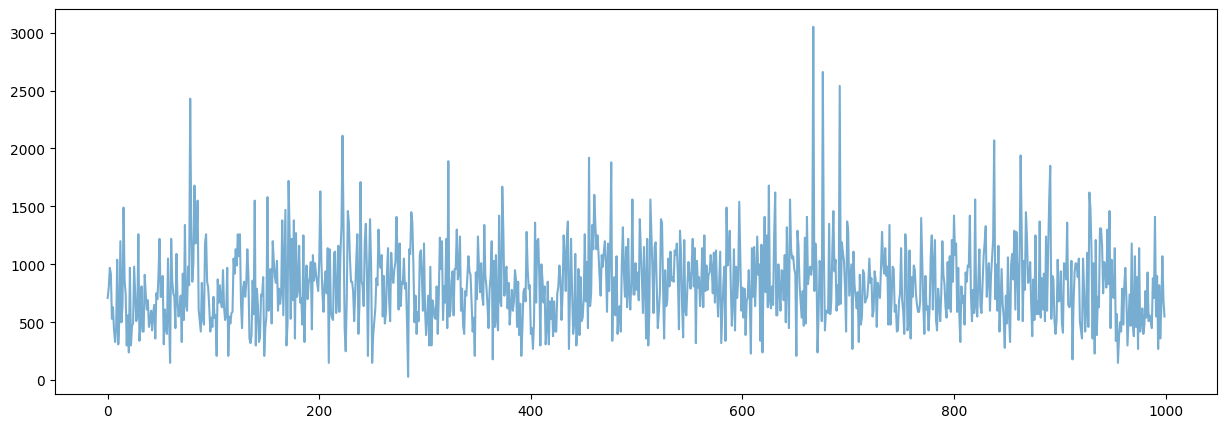

In [ ]:
def show_results():
    video_dir = Path("videos")
    if video_dir.exists():
        video_files = list(video_dir.glob("*.mp4"))
        print("📹 Videos generados:")
        for video in video_files:
            print(f"  - {video.name}")

    # Mostrar gráficas si existen datos de entrenamiento
    try:
        import pandas as pd
        if 'dqn_rewards' in globals():
            plot_training_progress(dqn_rewards, epsilons_dqn=dqn_epsilons)
        if 'ppo_rewards' in globals() and 'dqn_rewards' in globals():
            plot_training_progress(dqn_rewards, ppo_rewards)
    except:
        print("Ejecuta primero el entrenamiento para ver las gráficas")

show_results()